In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import norm
import scipy

from lattice_translocators import LEFTranslocator, LEFTranslocatorDynamicBoundary

### Extrusion dictionary

In [3]:
paramdict = {
    'CTCF_facestall': [1.0],
    'CTCF_backstall': [0.0],
    'CTCF_lifetime': [10.],
    'CTCF_offtime': [0.1],
    'LEF_lifetime': [50],
    'LEF_stalled_lifetime': [50],
    'LEF_birth': [0.1],
    'LEF_pause': [0],
    'LEF_separation': 100,
    'sites_per_monomer': 10,
    'monomers_per_replica': 100,
    'number_of_replica': 10,
    'steps': 200,
    'velocity_multiplier': 1
}

### Making Arrays

In [4]:
def make_site_array(site_types, 
                    values, 
                    at_ids=None, 
                    number_of_replica=1, 
                    **kwargs):
    
    assert site_types.max() < len(values), ('Number of values (%d) incompatible with number of site types (%d)'
                                            % (len(values), site_types.max()))
    
    prop_array = np.zeros(len(site_types), dtype=np.double)
    
    for i, value in enumerate(values):
        prop_array[site_types == i] = value
        
    if isinstance(at_ids, np.ndarray):
        mask = np.zeros(len(site_types), dtype=bool)
        mask[at_ids] = True
        
        prop_array[~mask] = 0
        
    return np.tile(prop_array, number_of_replica)

### CTCF arrays

In [5]:
def make_CTCF_arrays(site_types,
                     CTCF_left_positions,
                     CTCF_right_positions,
                     CTCF_facestall,
                     CTCF_backstall,
                     **kwargs):
    
    stall_left_array = make_site_array(site_types, CTCF_facestall, at_ids=CTCF_left_positions, **kwargs)
    stall_right_array = make_site_array(site_types, CTCF_facestall, at_ids=CTCF_right_positions, **kwargs)
    
    stall_left_array += make_site_array(site_types, CTCF_backstall, at_ids=CTCF_right_positions, **kwargs)
    stall_right_array += make_site_array(site_types, CTCF_backstall, at_idsids=CTCF_left_positions, **kwargs)
    
    return [stall_left_array, stall_right_array]

In [6]:
def make_CTCF_dynamic_arrays(site_types,
                             CTCF_lifetime,
                             CTCF_offtime,
                             sites_per_monomer,
                             velocity_multiplier,
                             **kwargs):
    
    CTCF_lifetime_array = make_site_array(site_types, CTCF_lifetime, **kwargs)
    CTCF_offtime_array = make_site_array(site_types, CTCF_offtime, **kwargs)
    
    CTCF_death_array = 1./ CTCF_lifetime_array / (velocity_multiplier * sites_per_monomer)
    CTCF_birth_array = 1./ CTCF_offtime_array / (velocity_multiplier * sites_per_monomer)

    return [CTCF_death_array, CTCF_birth_array]

### LEF arrays

single extruder function

In [7]:
def make_LEF_arrays(site_types,
                    LEF_lifetime,
                    LEF_stalled_lifetime,
                    LEF_birth,
                    LEF_pause,
                    sites_per_monomer,
                    velocity_multiplier,
                    **kwargs):
    
    lifetime_array = make_site_array(site_types, LEF_lifetime, **kwargs)
    stalled_lifetime_array = make_site_array(site_types, LEF_stalled_lifetime, **kwargs)
    
    birth_array = make_site_array(site_types, LEF_birth,at_ids=np.arange(len(site_types)//3+len(site_types)//(8), len(site_types), len(site_types)), **kwargs)
    pause_array = make_site_array(site_types, LEF_pause, **kwargs)
    
    death_array = 1./ lifetime_array / (velocity_multiplier * sites_per_monomer)
    stalled_death_array = 1./ stalled_lifetime_array / (velocity_multiplier * sites_per_monomer)

    return [death_array, stalled_death_array, birth_array, pause_array]

### Making extruders

In [8]:
def make_translocator(extrusion_engine, 
                      site_types,
                      CTCF_left_positions,
                      CTCF_right_positions,
                      **kwargs):

    LEF_separation = kwargs['LEF_separation']    
    velocity_multiplier = kwargs['velocity_multiplier'] 
    
    sites_per_monomer = kwargs['sites_per_monomer'] 
    
    number_of_replica = kwargs['number_of_replica'] 
    monomers_per_replica = kwargs['monomers_per_replica'] 

    number_of_monomers = number_of_replica * monomers_per_replica
    number_of_LEFs = number_of_monomers // LEF_separation
    
    sites_per_replica = monomers_per_replica*sites_per_monomer

    assert len(site_types) == sites_per_replica, ("Site type array (%d) doesn't match replica lattice size (%d)"
                                                  % (len(site_types), sites_per_replica))

    # Create arrays
    LEF_arrays = make_LEF_arrays(site_types, **kwargs)
    
    CTCF_arrays = make_CTCF_arrays(site_types, CTCF_left_positions, CTCF_right_positions, **kwargs)
    CTCF_dynamic_arrays = make_CTCF_dynamic_arrays(site_types, **kwargs)

    LEFTran = extrusion_engine(number_of_LEFs, *LEF_arrays, *CTCF_arrays, *CTCF_dynamic_arrays)

    if not isinstance(LEFTran, LEFTranslocatorDynamicBoundary):
        LEFTran.stallProbLeft = 1 - (1 - LEFTran.stallProbLeft) ** (1. / velocity_multiplier)
        LEFTran.stallProbRight = 1 - (1 - LEFTran.stallProbRight) ** (1. / velocity_multiplier)

    return LEFTran

### lattice structure

In [9]:
monomers_per_replica = paramdict['monomers_per_replica'] 
sites_per_monomer = paramdict['sites_per_monomer']

sites_per_replica = monomers_per_replica*sites_per_monomer

In [10]:
# Work with a single type of monomers (A, assigned to type index 0)
typedict = {'A': 0}

monomer_types = np.zeros(monomers_per_replica, dtype=int)
site_types = np.repeat(monomer_types, sites_per_monomer)
print(len(site_types))

1000


In [11]:
#see the lefs
paramdict['LEF_lifetime'] = [10000]
print(paramdict['LEF_separation'])
LEF_arrays = make_LEF_arrays(site_types, **paramdict)
print(np.nonzero(LEF_arrays[2]))


100
(array([ 458, 1458, 2458, 3458, 4458, 5458, 6458, 7458, 8458, 9458]),)


In [12]:
# LEF/CTCF properties in type A monomers may be obtained from the paramdict as follows
LEF_lifetime = paramdict['LEF_lifetime']
CTCF_facestall = paramdict['CTCF_facestall']

print(LEF_lifetime[typedict['A']], CTCF_facestall[typedict['A']])

10000 1.0


In [13]:
# Create some CTCF boundary sites
TAD_size = 10 # in monomers

CTCF_left_positions = np.arange(0, sites_per_replica, TAD_size*sites_per_monomer)
CTCF_right_positions = np.arange(0, sites_per_replica, TAD_size*sites_per_monomer)

# Analysis

### Kymograph analysis

In [14]:
paramdict_CTCF = {
    'CTCF_facestall': [1, 1],
    'CTCF_backstall': [0., 0.],
    'CTCF_lifetime': [1., 1.],
    'CTCF_offtime': [0.1, 1],
    'LEF_lifetime': [5000, 5000],
    'LEF_stalled_lifetime': [5000, 5000],
    'LEF_birth': [0.1, 0.1],
    'LEF_pause': [0, 0],
    'LEF_separation': 100,
    'sites_per_monomer': 10,
    'monomers_per_replica': 100,
    'number_of_replica': 10,
    'steps': 200,
    'velocity_multiplier': 1
}

In [15]:
# Let's make some strong and weak CTCF regions
typedict = {'strong_CTCF':0, 'weak_CTCF':1}

site_types[:sites_per_replica//2] = typedict['strong_CTCF']
site_types[sites_per_replica//2:] = typedict['weak_CTCF']

In [16]:
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.1, 1]
paramdict_CTCF['velocity_multiplier'] = 1.5
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [10000,10000]
paramdict_CTCF['CTCF_lifetime'] = [1.5, 1.5]

In [17]:
CTCF_arrays = make_CTCF_arrays(site_types, CTCF_left_positions, CTCF_right_positions, **paramdict_CTCF)
CTCF_dynamic_arrays = make_CTCF_dynamic_arrays(site_types, **paramdict_CTCF)

### functions for run length of boundary elements

In [18]:
def rle(x):
    """
    Run length encoding.
    Based on http://stackoverflow.com/a/32681075, which is based on the R rle function.
    
    Input
    -----
    x : array-like
    
    Returns
    -------
    start positions, run lengths, run values
    
    """
    x = np.asarray(x)
    n = len(x)
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([], dtype=x.dtype)
    
    starts = np.r_[0, np.flatnonzero(x[1:] != x[:-1]) + 1]
    lengths = np.diff(np.r_[starts, n])
    return starts, lengths, x[starts]

def get_bound_intervals_single(ctcf_array_on):
        aray_start, aray_length, aray_vals = rle(ctcf_array_on)
        single_run_lens = []
        for i in range(len(aray_vals)):
            if aray_vals[i] ==1:
                run =[aray_start[i],aray_start[i]+aray_length[i]]
                single_run_lens.append(run)
        return single_run_lens


def get_bound_intervals(ctcf_array):
    """
    Input
    -----
    ctcfaray : array_like
    ctcf_loc : CTCF location
    -----
    """
    all_run_len_array = []
    ctcf_location_aray = []
    ctcf_loc_aray = np.unique(ctcf_array[:,1])
    for ctcf_loc in ctcf_loc_aray:
        filtered_ctcfaray = ctcf_array[ctcf_array[:, 1] == ctcf_loc][:,2]
        single_run = get_bound_intervals_single(filtered_ctcfaray)
        all_run_len_array.append(single_run)
        ctcf_location_aray.append(ctcf_loc)
    return all_run_len_array, ctcf_location_aray
        
def plot_intervals(ctcf_array):
    bound_interval_mat, ctcf_location_array = get_bound_intervals(ctcf_array)
    for i in range(len(ctcf_location_array)):
        for j in range(len(bound_interval_mat[i])):
            plt.plot(bound_interval_mat[i][j],[ctcf_location_array[i],ctcf_location_array[i]]
                    ,'k',solid_capstyle='butt',linewidth=3.5,alpha=0.3)



def get_occupancy(a):
    occupancy = sum([(get_bound_intervals_single(a)[i][1]-get_bound_intervals_single(a)[i][0]) for i in range(len(get_bound_intervals_single(a)))])/len(a)
    return(occupancy)
    

In [19]:
a = [1, 0, 0, 0, 0,1,1,1,0,0,0]
print(rle(a))
print(get_bound_intervals_single(a))
print(sum([(get_bound_intervals_single(a)[i][1]-get_bound_intervals_single(a)[i][0]) for i in range(len(get_bound_intervals_single(a)))])/len(a))
print(get_occupancy(a))

(array([0, 1, 5, 8]), array([1, 4, 3, 3]), array([1, 0, 1, 0]))
[[0, 1], [5, 8]]
0.36363636363636365
0.36363636363636365


In [20]:
loc_hist = []


traj = 300 
for i in range(150):
    
    translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                     site_types,
                                     CTCF_left_positions,
                                     CTCF_right_positions, 
                                     **paramdict_CTCF)
    
    lefhist=[]
    rightctcfhist=[]
    leftctcfhist=[]
    for _ in range(traj+1):
        translocator.step()
        #print(translocator.LEFs.copy())
        lefhist.append(translocator.LEFs.copy())
        for ctcf_index in CTCF_right_positions:
            #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
            #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
            if ctcf_index >450:
                rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
            else:
                leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])
    loc_hist.append(np.asarray(lefhist)[traj][0])

w = 10
data_r = np.asarray(loc_hist)[:,1]
bins_r=np.arange(min(data_r), max(data_r) + w/2,w)
data_l=np.asarray(loc_hist)[:,0]
bins_l=np.arange(min(data_l), max(data_l) + w/2,w)


(array([ 1.,  3., 21.,  7., 11.,  9.,  7.,  9.,  7.,  4.,  8.,  1., 42.,
         3.,  2.,  4.,  2.,  2.,  1.,  0.,  1.,  2.]),
 array([175., 185., 195., 205., 215., 225., 235., 245., 255., 265., 275.,
        285., 295., 305., 315., 325., 335., 345., 355., 365., 375., 385.,
        395.]),
 <BarContainer object of 22 artists>)

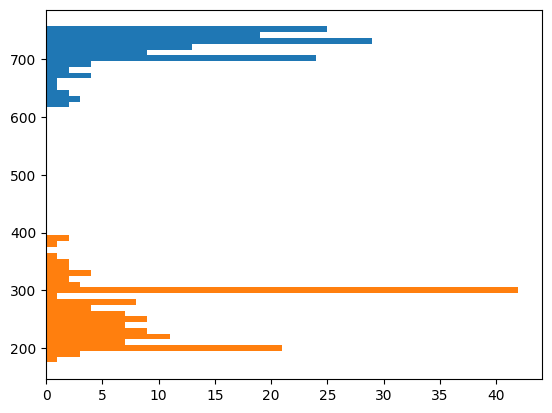

In [21]:
#print(np.asarray(loc_hist)[:,0])

s = np.histogram(np.asarray(loc_hist)[:,1])
bins_n = 15
w = 10
data_r = np.asarray(loc_hist)[:,1]
bins_r=np.arange(min(data_r), max(data_r) + w/2,w)
data_l=np.asarray(loc_hist)[:,0]
bins_l=np.arange(min(data_l), max(data_l) + w/2,w)
#plt.barh(s[0],s[1][:-1])
plt.hist(data_r, bins = bins_r,orientation='horizontal')
plt.hist(data_l, bins = bins_l, orientation='horizontal')

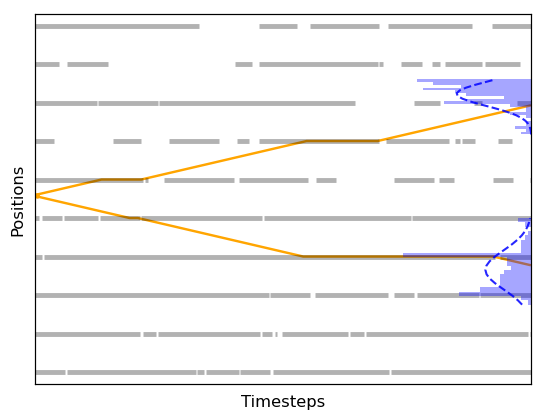

In [22]:
translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                     site_types,
                                     CTCF_left_positions,
                                     CTCF_right_positions, 
                                     **paramdict_CTCF)
    
lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
for _ in range(300):
    translocator.step()
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

#print(np.asarray(lefhist))    
#print(np.asarray(lefhist)[299][0])
lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1.75,color='orange')
ax.plot(lefaray[::1,0,0],linewidth=1.75,color='orange')
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
#print(np.array(rightctcfhist))
plot_intervals(ctcfrightaray)
plot_intervals(ctcfleftaray)
ax.set_yticks([])
ax.set_xticks([])
#print(np.array(rightctcfhist)[::,0])
axn=ax.twiny()
#axn.invert_xaxis()

#for right leg
_, bins, _ = axn.hist(data_r, 20,orientation='horizontal', density=1, alpha=0.35,color='blue')
mu, sigma = scipy.stats.norm.fit(data_r)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
axn.plot( best_fit_line,bins,'--b',alpha=0.85)


#for left leg
_, bins, _ = axn.hist(data_l, 20,orientation='horizontal', density=1, alpha=0.35,color='blue')
mu, sigma = scipy.stats.norm.fit(data_l)
best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
axn.plot( best_fit_line,bins,'--b',alpha=0.85)
axn.invert_xaxis()




axn.set_yticks([])
axn.set_xticks([])
axn.set_xlim(0.08500,0)
max_lim = np.shape(lefaray[::1,0,1])[0]
ax.set_ylim(-30,930)
ax.set_xlim(0,max_lim)
ax.set_ylabel('Positions',fontsize=11.75)
ax.set_xlabel('Timesteps',fontsize =11.75)
#plt.xticks( [],[])
#plt.tick_params(axis='y',off)
plt.savefig('kymograph.png')
plt.show()

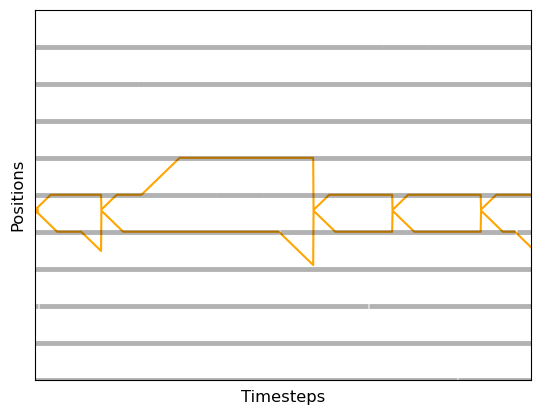

In [23]:
#wt
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_stalled_lifetime'] = [50, 50]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]

translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)


lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
for _ in range(1300):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1.5,color='orange')
ax.plot(lefaray[::1,0,0],linewidth=1.5,color='orange')
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
ax.set_yticks([])
ax.set_xticks([])



plot_intervals(ctcfrightaray)
plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,1300)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_wt.png')
plt.show()

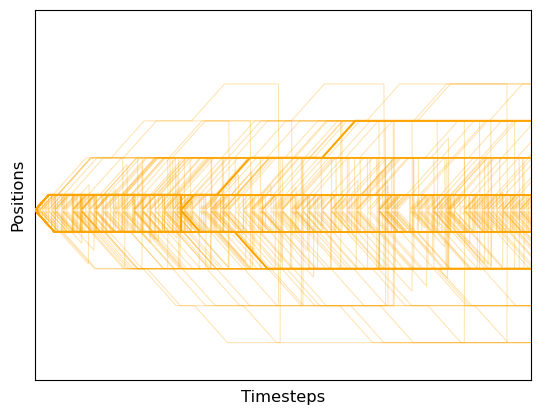

In [24]:
#wt
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_stalled_lifetime'] = [50, 50]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]

translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)


lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
traj = 1500
for _ in range(traj+1):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

total_trials = 100
lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1.5,color='orange',zorder =total_trials+1)
ax.plot(lefaray[::1,0,0],linewidth=1.5,color='orange',zorder = total_trials+1)
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
ax.set_yticks([])
ax.set_xticks([])


loc_hist = []


for i in range(total_trials):
    translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                     site_types,
                                     CTCF_left_positions,
                                     CTCF_right_positions, 
                                     **paramdict_CTCF)
    
    lefhist=[]
    rightctcfhist=[]
    leftctcfhist=[]
    for _ in range(traj+1):
        translocator.step()
        #print(translocator.LEFs.copy())
        lefhist.append(translocator.LEFs.copy())
        for ctcf_index in CTCF_right_positions:
            #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
            #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
            if ctcf_index >450:
                rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
            else:
                leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])
    loc_hist.append(np.asarray(lefhist)[traj][0])

    lefaray=(np.asarray(lefhist))
    ctcfrightaray = np.array(rightctcfhist)
    ctcfleftaray = np.array(leftctcfhist)
    ax.plot(lefaray[::1,0,1],linewidth=0.75,color='orange',alpha=0.3,zorder=i)
    ax.plot(lefaray[::1,0,0],linewidth=0.75,color='orange',alpha=0.3,zorder=i)   
    ax.set_yticks([])
    ax.set_xticks([])

np.savetxt('hist_for_norm.dat',loc_hist)
#plot_intervals(ctcfrightaray)
#plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,1500)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
#plt.savefig('kymograph_map_norm.png')
plt.show()

In [25]:
# Create some CTCF boundary sites
TAD_size = 5 # in monomers


CTCF_left_positions = np.arange(0, sites_per_replica, TAD_size*sites_per_monomer)
CTCF_right_positions = np.arange(0, sites_per_replica, TAD_size*sites_per_monomer)


CTCF_arrays = make_CTCF_arrays(site_types, CTCF_left_positions, CTCF_right_positions, **paramdict_CTCF)
CTCF_dynamic_arrays = make_CTCF_dynamic_arrays(site_types, **paramdict_CTCF)

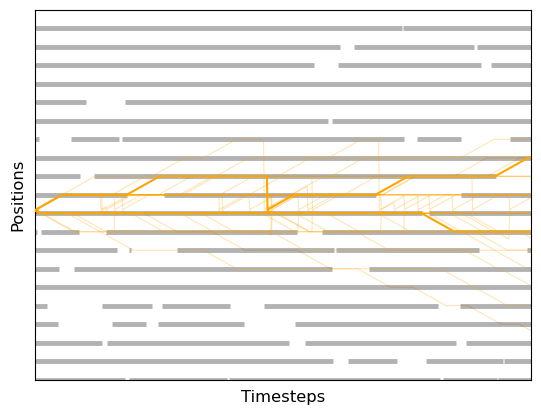

In [26]:
#wt
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [3, 3]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_stalled_lifetime'] = [50, 50]
paramdict_CTCF['CTCF_lifetime'] = [30, 30]

translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)


lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
traj = 1000
for _ in range(traj+1):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

total_trials = 15
lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1.5,color='orange',zorder =total_trials+1)
ax.plot(lefaray[::1,0,0],linewidth=1.5,color='orange',zorder = total_trials+1)
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
ax.set_yticks([])
ax.set_xticks([])



ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
plot_intervals(ctcfrightaray)
plot_intervals(ctcfleftaray)

loc_hist = []
for i in range(total_trials):
    translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                     site_types,
                                     CTCF_left_positions,
                                     CTCF_right_positions, 
                                     **paramdict_CTCF)
    
    lefhist=[]
    rightctcfhist=[]
    leftctcfhist=[]
    for _ in range(traj+1):
        translocator.step()
        #print(translocator.LEFs.copy())
        lefhist.append(translocator.LEFs.copy())
        for ctcf_index in CTCF_right_positions:
            #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
            #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
            if ctcf_index >450:
                rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
            else:
                leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])
    loc_hist.append(np.asarray(lefhist)[traj][0])

    lefaray=(np.asarray(lefhist))
    ctcfrightaray = np.array(rightctcfhist)
    ctcfleftaray = np.array(leftctcfhist)
    ax.plot(lefaray[::1,0,1],linewidth=0.75,color='orange',alpha=0.3,zorder=i)
    ax.plot(lefaray[::1,0,0],linewidth=0.75,color='orange',alpha=0.3,zorder=i)   
    ax.set_yticks([])
    ax.set_xticks([])

#np.savetxt('hist_for_norm_ctcf_lifetime_%s.dat'%(paramdict_CTCF['CTCF_lifetime'][1]),loc_hist)
#plot_intervals(ctcfrightaray)
#plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,750)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_norm_ctcf_lifetime_%s.png'%(paramdict_CTCF['CTCF_lifetime'][1]))
plt.show()

/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/ipykernel_launcher.py:31: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


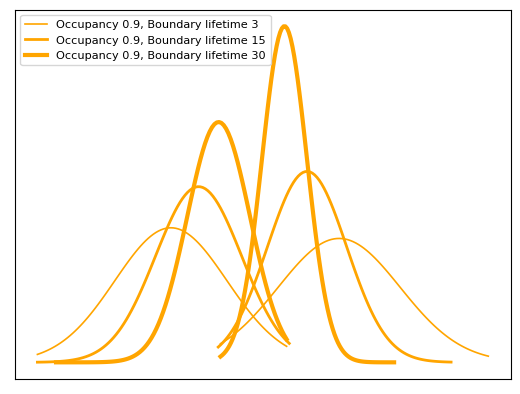

In [28]:



samples = [3, 15, 30]


colors = ['orange', 'maroon', 'steelblue']
for sample in samples:
    loc_hist = np.loadtxt('data/histogram/hist_for_norm_ctcf_lifetime_%s.dat'%sample)



    bins_n = 15
    w = 10
    data_r = np.asarray(loc_hist)[:,1]
    bins_r=np.arange(min(data_r), max(data_r) + w/2,w)
    data_l=np.asarray(loc_hist)[:,0]
    bins_l=np.arange(min(data_l), max(data_l) + w/2,w)
        
    
    
    mu, std = norm.fit(data_r)
    #plt.hist(data_r,bins=bins_r,density=True, alpha = 0.3,color=colors[samples.index(sample)])
    xmin, xmax = min(data_r)-95, max(data_r)+95
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'b', linewidth=1+sample/15,color='orange', label='Occupancy 0.9, Boundary lifetime %s'%sample)
    
    mu, std = norm.fit(data_l)
    #plt.hist(data_l,bins=bins_l,density=True, alpha = 0.3,color=colors[samples.index(sample)])
    xmin, xmax = min(data_l)-95, max(data_l)+95
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'b', linewidth=1+sample/15,color='orange')
plt.legend(fontsize =8.1)
plt.yticks([])
plt.xticks([])
plt.savefig('normal_dist_boundary.png')
plt.show()

def make_LEF_arrays(site_types,
                    LEF_lifetime,
                    LEF_stalled_lifetime,
                    LEF_birth,
                    LEF_pause,
                    sites_per_monomer,
                    velocity_multiplier,
                    **kwargs):
    
    lifetime_array = make_site_array(site_types, LEF_lifetime, **kwargs)
    stalled_lifetime_array = make_site_array(site_types, LEF_stalled_lifetime, **kwargs)
    
    birth_array = make_site_array(site_types, LEF_birth,at_ids=np.arange(len(site_types)//3+len(site_types)//(7), len(site_types), len(site_types)), **kwargs)
    pause_array = make_site_array(site_types, LEF_pause, **kwargs)
    
    death_array = 1./ lifetime_array / (velocity_multiplier * sites_per_monomer)
    stalled_death_array = 1./ stalled_lifetime_array / (velocity_multiplier * sites_per_monomer)

    return [death_array, stalled_death_array, birth_array, pause_array]

def make_translocator(extrusion_engine, 
                      site_types,
                      CTCF_left_positions,
                      CTCF_right_positions,
                      **kwargs):

    LEF_separation = kwargs['LEF_separation']    
    velocity_multiplier = kwargs['velocity_multiplier'] 
    
    sites_per_monomer = kwargs['sites_per_monomer'] 
    
    number_of_replica = kwargs['number_of_replica'] 
    monomers_per_replica = kwargs['monomers_per_replica'] 

    number_of_monomers = number_of_replica * monomers_per_replica
    number_of_LEFs = number_of_monomers // LEF_separation
    
    sites_per_replica = monomers_per_replica*sites_per_monomer

    assert len(site_types) == sites_per_replica, ("Site type array (%d) doesn't match replica lattice size (%d)"
                                                  % (len(site_types), sites_per_replica))

    # Create arrays
    LEF_arrays = make_LEF_arrays(site_types, **kwargs)
    
    CTCF_arrays = make_CTCF_arrays(site_types, CTCF_left_positions, CTCF_right_positions, **kwargs)
    CTCF_dynamic_arrays = make_CTCF_dynamic_arrays(site_types, **kwargs)

    LEFTran = extrusion_engine(number_of_LEFs, *LEF_arrays, *CTCF_arrays, *CTCF_dynamic_arrays)

    if not isinstance(LEFTran, LEFTranslocatorDynamicBoundary):
        LEFTran.stallProbLeft = 1 - (1 - LEFTran.stallProbLeft) ** (1. / velocity_multiplier)
        LEFTran.stallProbRight = 1 - (1 - LEFTran.stallProbRight) ** (1. / velocity_multiplier)

    return LEFTran

def rle(x):
    """
    Run length encoding.
    Based on http://stackoverflow.com/a/32681075, which is based on the R rle function.
    
    Input
    -----
    x : array-like
    
    Returns
    -------
    start positions, run lengths, run values
    
    """
    x = np.asarray(x)
    n = len(x)
    if n == 0:
        return np.array([], dtype=int), np.array([], dtype=int), np.array([], dtype=x.dtype)
    
    starts = np.r_[0, np.flatnonzero(x[1:] != x[:-1]) + 1]
    lengths = np.diff(np.r_[starts, n])
    return starts, lengths, x[starts]

def get_bound_intervals_single(ctcf_array_on):
        aray_start, aray_length, aray_vals = rle(ctcf_array_on)
        single_run_lens = []
        for i in range(len(aray_vals)):
            if aray_vals[i] ==1:
                run =[aray_start[i],aray_start[i]+aray_length[i]]
                single_run_lens.append(run)
        return single_run_lens


def get_bound_intervals(ctcf_array):
    """
    Input
    -----
    ctcfaray : array_like
    ctcf_loc : CTCF location
    -----
    """
    all_run_len_array = []
    ctcf_location_aray = []
    ctcf_loc_aray = np.unique(ctcf_array[:,1])
    for ctcf_loc in ctcf_loc_aray:
        filtered_ctcfaray = ctcf_array[ctcf_array[:, 1] == ctcf_loc][:,2]
        single_run = get_bound_intervals_single(filtered_ctcfaray)
        all_run_len_array.append(single_run)
        ctcf_location_aray.append(ctcf_loc)
    return all_run_len_array, ctcf_location_aray
        
def plot_intervals(ctcf_array):
    bound_interval_mat, ctcf_location_array = get_bound_intervals(ctcf_array)
    for i in range(len(ctcf_location_array)):
        for j in range(len(bound_interval_mat[i])):
            plt.plot(bound_interval_mat[i][j],[ctcf_location_array[i],ctcf_location_array[i]]
                    ,'k',solid_capstyle='butt',linewidth=3,alpha=0.3)

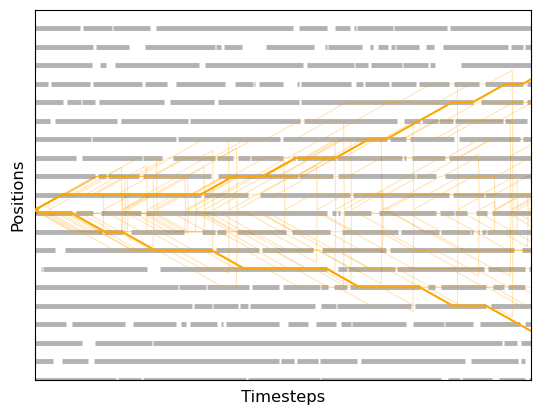

In [29]:
#wt
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.714,0.714]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_stalled_lifetime'] = [50, 50]
paramdict_CTCF['CTCF_lifetime'] = [5,5]

translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)


lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
traj = 1000
for _ in range(traj+1):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

total_trials = 15
lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1.5,color='orange',zorder =total_trials+1)
ax.plot(lefaray[::1,0,0],linewidth=1.5,color='orange',zorder = total_trials+1)
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
ax.set_yticks([])
ax.set_xticks([])



ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
plot_intervals(ctcfrightaray)
plot_intervals(ctcfleftaray)

loc_hist = []
for i in range(total_trials):
    translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                     site_types,
                                     CTCF_left_positions,
                                     CTCF_right_positions, 
                                     **paramdict_CTCF)
    
    lefhist=[]
    rightctcfhist=[]
    leftctcfhist=[]
    for _ in range(traj+1):
        translocator.step()
        #print(translocator.LEFs.copy())
        lefhist.append(translocator.LEFs.copy())
        for ctcf_index in CTCF_right_positions:
            #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
            #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
            if ctcf_index >450:
                rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
            else:
                leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])
    loc_hist.append(np.asarray(lefhist)[traj][0])

    lefaray=(np.asarray(lefhist))
    ctcfrightaray = np.array(rightctcfhist)
    ctcfleftaray = np.array(leftctcfhist)
    ax.plot(lefaray[::1,0,1],linewidth=0.75,color='orange',alpha=0.3,zorder=i)
    ax.plot(lefaray[::1,0,0],linewidth=0.75,color='orange',alpha=0.3,zorder=i)   
    ax.set_yticks([])
    ax.set_xticks([])

#np.savetxt('hist_for_norm_multiple1_ctcf_lifetime_%s.dat'%(paramdict_CTCF['CTCF_lifetime'][1]),loc_hist)
#plot_intervals(ctcfrightaray)
#plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,750)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_norm_multile1_ctcf_lifetime_%s.png'%(paramdict_CTCF['CTCF_lifetime'][1]))
plt.show()

In [30]:
# Create some CTCF boundary sites
TAD_size = 5 # in monomers

CTCF_left_positions = np.sort(np.ndarray.flatten(np.array([np.arange(i, sites_per_replica, TAD_size*sites_per_monomer) for i in range(1)])))
CTCF_right_positions = np.sort(np.ndarray.flatten(np.array([np.arange(i, sites_per_replica, TAD_size*sites_per_monomer) for i in range(1)])))


CTCF_arrays = make_CTCF_arrays(site_types, CTCF_left_positions, CTCF_right_positions, **paramdict_CTCF)
CTCF_dynamic_arrays = make_CTCF_dynamic_arrays(site_types, **paramdict_CTCF)
print(CTCF_left_positions)

[  0  50 100 150 200 250 300 350 400 450 500 550 600 650 700 750 800 850
 900 950]


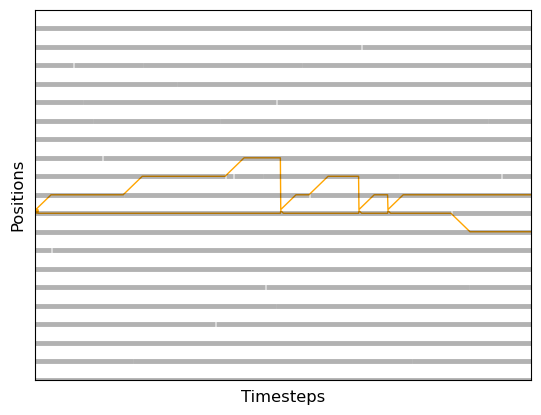

In [55]:
#normal
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_stalled_lifetime'] = [50, 50]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]


translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)

lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
for _ in range(1300):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1,color='orange')
ax.plot(lefaray[::1,0,0],linewidth=1,color='orange')
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
plot_intervals(ctcfrightaray)
plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,1300)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_wap.png')
plt.show()

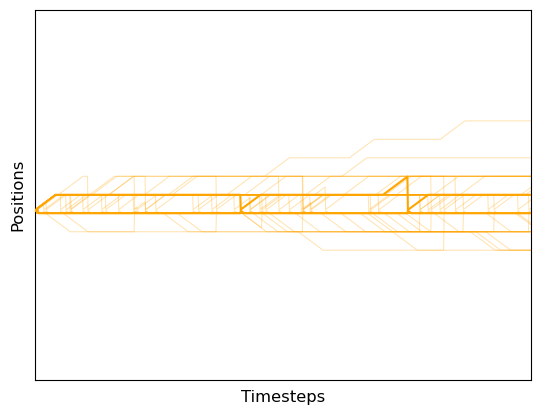

In [58]:
#normal
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_stalled_lifetime'] = [50,50]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]

translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)
traj= 1000
total_trials = 30
lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
for _ in range(traj+1):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1.5,color='orange',zorder=total_trials+1)
ax.plot(lefaray[::1,0,0],linewidth=1.5,color='orange',zorder=total_trials+1)
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
ax.set_yticks([])
ax.set_xticks([])



loc_hist = []
for i in range(total_trials):
    translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                     site_types,
                                     CTCF_left_positions,
                                     CTCF_right_positions, 
                                     **paramdict_CTCF)
    
    lefhist=[]
    rightctcfhist=[]
    leftctcfhist=[]
    for _ in range(traj+1):
        translocator.step()
        #print(translocator.LEFs.copy())
        lefhist.append(translocator.LEFs.copy())
        for ctcf_index in CTCF_right_positions:
            #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
            #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
            if ctcf_index >450:
                rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
            else:
                leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])
    loc_hist.append(np.asarray(lefhist)[traj][0])

    lefaray=(np.asarray(lefhist))
    ctcfrightaray = np.array(rightctcfhist)
    ctcfleftaray = np.array(leftctcfhist)
    ax.plot(lefaray[::1,0,1],linewidth=0.75,color='orange',alpha=0.3)
    ax.plot(lefaray[::1,0,0],linewidth=0.75,color='orange',alpha=0.3)   
    ax.set_yticks([])
    ax.set_xticks([])

np.savetxt('data/histogram/hist_for_norm.dat',loc_hist)
#plot_intervals(ctcfrightaray)
#plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,traj)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_life.png')
plt.show()

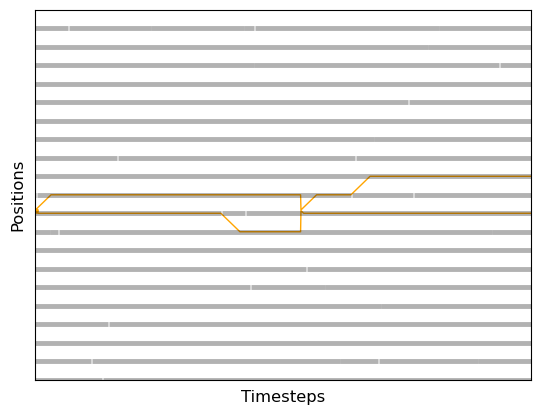

In [47]:
#lifetime
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [150,150]
paramdict_CTCF['LEF_stalled_lifetime'] = [150, 150]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]


translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)

lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
for _ in range(1300):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1,color='orange')
ax.plot(lefaray[::1,0,0],linewidth=1,color='orange')
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
plot_intervals(ctcfrightaray)
plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,1300)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_wap.png')
plt.show()

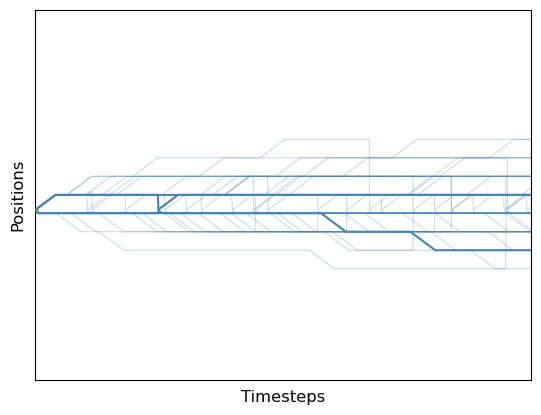

In [51]:
#wapl
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [150,150]
paramdict_CTCF['LEF_stalled_lifetime'] = [150, 150]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]

translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)
traj= 1000
total_trials = 30
lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
for _ in range(traj+1):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1.5,color='steelblue',zorder=total_trials+1)
ax.plot(lefaray[::1,0,0],linewidth=1.5,color='steelblue',zorder=total_trials+1)
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
ax.set_yticks([])
ax.set_xticks([])



loc_hist = []
for i in range(total_trials):
    translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                     site_types,
                                     CTCF_left_positions,
                                     CTCF_right_positions, 
                                     **paramdict_CTCF)
    
    lefhist=[]
    rightctcfhist=[]
    leftctcfhist=[]
    for _ in range(traj+1):
        translocator.step()
        #print(translocator.LEFs.copy())
        lefhist.append(translocator.LEFs.copy())
        for ctcf_index in CTCF_right_positions:
            #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
            #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
            if ctcf_index >450:
                rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
            else:
                leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])
    loc_hist.append(np.asarray(lefhist)[traj][0])

    lefaray=(np.asarray(lefhist))
    ctcfrightaray = np.array(rightctcfhist)
    ctcfleftaray = np.array(leftctcfhist)
    ax.plot(lefaray[::1,0,1],linewidth=0.75,color='steelblue',alpha=0.3)
    ax.plot(lefaray[::1,0,0],linewidth=0.75,color='steelblue',alpha=0.3)   
    ax.set_yticks([])
    ax.set_xticks([])

np.savetxt('data/histogram/hist_for_life.dat',loc_hist)
#plot_intervals(ctcfrightaray)
#plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,traj)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_life.png')
plt.show()

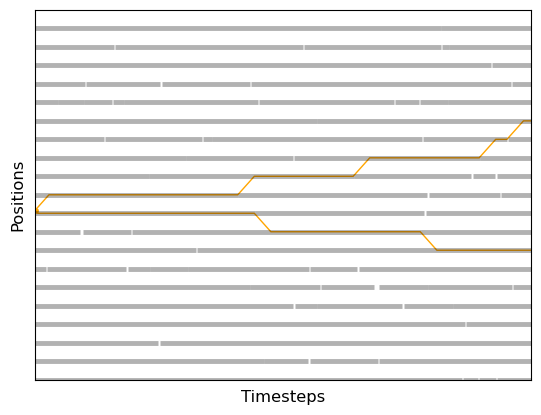

In [52]:
#velocity

# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 3
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [150,150]
paramdict_CTCF['LEF_stalled_lifetime'] = [150, 150]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]


translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)

lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
for _ in range(3000):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1,color='orange')
ax.plot(lefaray[::1,0,0],linewidth=1,color='orange')
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
plot_intervals(ctcfrightaray)
plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,1500)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_pds.png')
plt.show()

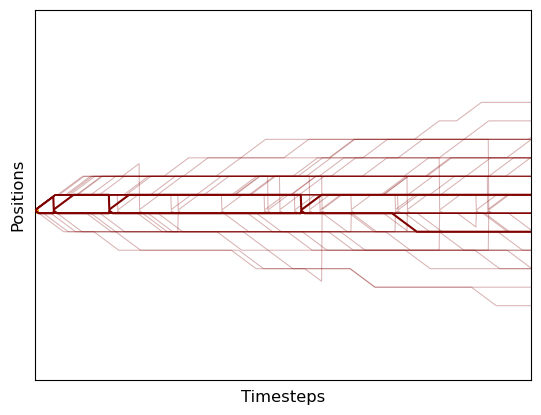

In [53]:
#pds5
#wt
# updating some of the parameters for kymograph
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 3
paramdict_CTCF['number_of_replica'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_stalled_lifetime'] = [50, 50]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]





translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)
traj = 1000
total_trials = 30
lefhist=[]
rightctcfhist=[]
leftctcfhist=[]
for _ in range(traj+1):
    translocator.step()
    #print(translocator.LEFs.copy())
    lefhist.append(translocator.LEFs.copy())
    for ctcf_index in CTCF_right_positions:
        #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
        #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
        if ctcf_index >450:
            rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
        else:
            leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])

lefaray=(np.asarray(lefhist))
ctcfrightaray = np.array(rightctcfhist)
ctcfleftaray = np.array(leftctcfhist)
ax=plt.axes()
ax.plot(lefaray[::1,0,1],linewidth=1.5,color='maroon',zorder=total_trials+1)
ax.plot(lefaray[::1,0,0],linewidth=1.5,color='maroon',zorder=total_trials+1)
ax.scatter(1,lefaray[1][0][1],color='orange',s=5)
ax.scatter(1,lefaray[1][0][0],color='orange',s=5)
ax.set_yticks([])
ax.set_xticks([])


loc_hist = []

for i in range(total_trials):
    translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                     site_types,
                                     CTCF_left_positions,
                                     CTCF_right_positions, 
                                     **paramdict_CTCF)
    
    lefhist=[]
    rightctcfhist=[]
    leftctcfhist=[]
    for _ in range(traj+1):
        translocator.step()
        #print(translocator.LEFs.copy())
        lefhist.append(translocator.LEFs.copy())
        for ctcf_index in CTCF_right_positions:
            #print([ctcf_index,translocator.stallProbRight[ctcf_index]])
            #print([ctcf_index,translocator.stallProbLeft[ctcf_index]])
            if ctcf_index >450:
                rightctcfhist.append([_,ctcf_index, translocator.stallProbRight[ctcf_index]])
            else:
                leftctcfhist.append([_,ctcf_index,translocator.stallProbLeft[ctcf_index]])
    loc_hist.append(np.asarray(lefhist)[traj][0])

    lefaray=(np.asarray(lefhist))
    ctcfrightaray = np.array(rightctcfhist)
    ctcfleftaray = np.array(leftctcfhist)
    ax.plot(lefaray[::1,0,1],linewidth=0.75,color='maroon',alpha=0.3)
    ax.plot(lefaray[::1,0,0],linewidth=0.75,color='maroon',alpha=0.3)   
    ax.set_yticks([])
    ax.set_xticks([])

np.savetxt('data/histogram/hist_for_vel.dat',loc_hist)
#plot_intervals(ctcfrightaray)
#plot_intervals(ctcfleftaray)
plt.ylim(0,1000)
plt.xlim(0,traj)
plt.xlabel('Timesteps',fontsize=11.75)
ax.set_yticks([])
ax.set_xticks([])
plt.ylabel('Positions',fontsize=11.75)
plt.savefig('kymograph_map_vel.png')
plt.show()

/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
/home1/rahmanin/.conda/envs/openwpoly/lib/python3.7/site-packages/ipykernel_launcher.py:42: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.


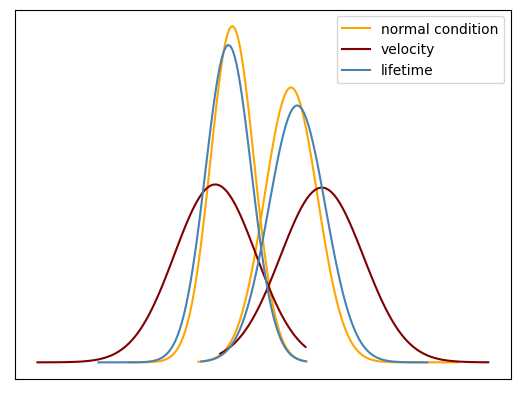

In [59]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt


samples = ['norm', 'vel', 'life']


colors = ['orange', 'maroon', 'steelblue']
for sample in samples:
    loc_hist = np.loadtxt('data/histogram/hist_for_%s.dat'%sample)



    bins_n = 15
    w = 10
    data_r = np.asarray(loc_hist)[:,1]
    bins_r=np.arange(min(data_r), max(data_r) + w/2,w)
    data_l=np.asarray(loc_hist)[:,0]
    bins_l=np.arange(min(data_l), max(data_l) + w/2,w)
    if sample =='norm':
        label = 'normal condition'
    elif sample =='vel':
        label = 'velocity'
    elif sample =='life':
        label = 'lifetime'
        
    
    
    mu, std = norm.fit(data_r)
    #plt.hist(data_r,bins=bins_r,density=True, alpha = 0.3,color=colors[samples.index(sample)])
    xmin, xmax = min(data_r)-95, max(data_r)+95
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'b', linewidth=1.5,color=colors[samples.index(sample)], label=label)
    
    mu, std = norm.fit(data_l)
    #plt.hist(data_l,bins=bins_l,density=True, alpha = 0.3,color=colors[samples.index(sample)])
    xmin, xmax = min(data_l)-95, max(data_l)+95
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'b', linewidth=1.5,color=colors[samples.index(sample)])
plt.legend()
plt.yticks([])
plt.xticks([])
plt.savefig('normal_dist.png')
plt.show()

### Lattice-based contact maps

For multiple extruders we need to modify "make_LEF_arrays" function.

In [96]:
def make_LEF_arrays(site_types,
                    LEF_lifetime,
                    LEF_stalled_lifetime,
                    LEF_birth,
                    LEF_pause,
                    sites_per_monomer,
                    velocity_multiplier,
                    **kwargs):
    
    lifetime_array = make_site_array(site_types, LEF_lifetime, **kwargs)
    stalled_lifetime_array = make_site_array(site_types, LEF_stalled_lifetime, **kwargs)
    
    birth_array = make_site_array(site_types, LEF_birth, **kwargs)
    pause_array = make_site_array(site_types, LEF_pause, **kwargs)
    
    death_array = 1./ lifetime_array / (velocity_multiplier * sites_per_monomer)
    stalled_death_array = 1./ stalled_lifetime_array / (velocity_multiplier * sites_per_monomer)

    return [death_array, stalled_death_array, birth_array, pause_array]

In [97]:
def make_translocator(extrusion_engine, 
                      site_types,
                      CTCF_left_positions,
                      CTCF_right_positions,
                      **kwargs):

    LEF_separation = kwargs['LEF_separation']    
    velocity_multiplier = kwargs['velocity_multiplier'] 
    
    sites_per_monomer = kwargs['sites_per_monomer'] 
    
    number_of_replica = kwargs['number_of_replica'] 
    monomers_per_replica = kwargs['monomers_per_replica'] 

    number_of_monomers = number_of_replica * monomers_per_replica
    number_of_LEFs = number_of_monomers // LEF_separation
    
    sites_per_replica = monomers_per_replica*sites_per_monomer

    assert len(site_types) == sites_per_replica, ("Site type array (%d) doesn't match replica lattice size (%d)"
                                                  % (len(site_types), sites_per_replica))

    # Create arrays
    LEF_arrays = make_LEF_arrays(site_types, **kwargs)
    
    CTCF_arrays = make_CTCF_arrays(site_types, CTCF_left_positions, CTCF_right_positions, **kwargs)
    CTCF_dynamic_arrays = make_CTCF_dynamic_arrays(site_types, **kwargs)

    LEFTran = extrusion_engine(number_of_LEFs, *LEF_arrays, *CTCF_arrays, *CTCF_dynamic_arrays)

    if not isinstance(LEFTran, LEFTranslocatorDynamicBoundary):
        LEFTran.stallProbLeft = 1 - (1 - LEFTran.stallProbLeft) ** (1. / velocity_multiplier)
        LEFTran.stallProbRight = 1 - (1 - LEFTran.stallProbRight) ** (1. / velocity_multiplier)

    return LEFTran

In [98]:
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_separation'] = 10 
paramdict_CTCF['number_of_replica'] =10
paramdict_CTCF['CTCF_offtime'] = [1, 0.1]

translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)

In [99]:
trajectory_length = 1000 * paramdict['sites_per_monomer']
hist = []

for _ in range(trajectory_length):
    translocator.step()
    hist.append(translocator.LEFs.copy())

In [100]:
def map_from_lefs(dset, sites_per_replica):
    
    ll = np.mod(dset.reshape((-1, 2)), sites_per_replica)
    ll = ll[ll[:,1] > ll[:,0]]
    
    lmap = np.histogram2d(ll[:,0], ll[:,1], np.arange(sites_per_replica))[0]
    
    return (lmap + lmap.T)

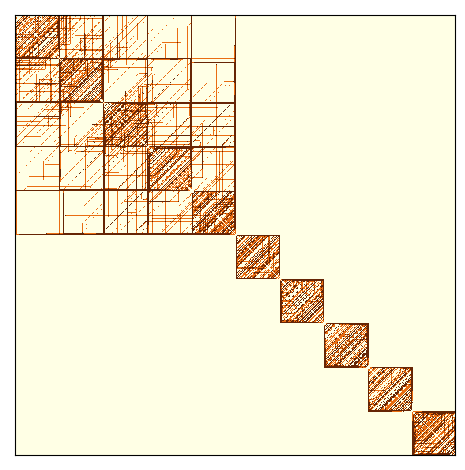

In [101]:
kymograph = map_from_lefs(np.asarray(hist), sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False, cmap='YlOrBr') 
#plt.title('Lifetime=%s, separation=%s, velocity=%s'%(paramdict_CTCF['LEF_lifetime'][1], paramdict_CTCF['LEF_separation']
#                                                    ,paramdict_CTCF['velocity_multiplier']),fontsize=8.5)            
#plt.title('CTCF_offtime=%s, CTCF_facestall=%s' % (paramdict['CTCF_offtime'],
#                                                  paramdict['CTCF_facestall']),
#          fontsize=12)

plt.xticks([])
plt.yticks([])

plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.savefig('contact_map.png')
plt.show()                       
            

# wild-type 

In [118]:
paramdict_CTCF['CTCF_facestall'] = [1., 1.]
paramdict_CTCF['CTCF_offtime'] = [0.115, 0.115]
paramdict_CTCF['velocity_multiplier'] = 1
paramdict_CTCF['LEF_lifetime'] = [50,50]
paramdict_CTCF['LEF_stalled_lifetime'] = [50, 50]
paramdict_CTCF['CTCF_lifetime'] = [11.5, 11.5]
paramdict_CTCF['LEF_separation'] = 10 
paramdict_CTCF['number_of_replica'] =10


In [119]:
translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)

In [120]:
trajectory_length = 1000 * paramdict['sites_per_monomer']
hist_wt = []

for _ in range(trajectory_length):
    translocator.step()
    hist_wt.append(translocator.LEFs.copy())

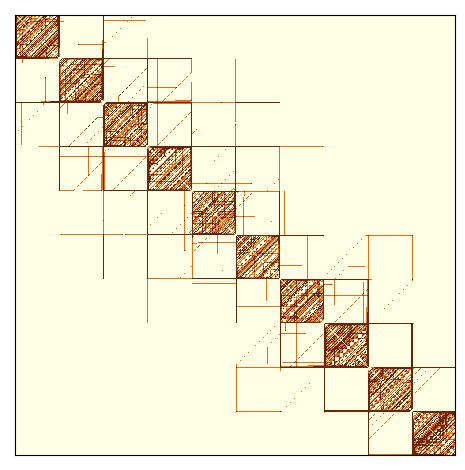

In [121]:
kymograph = map_from_lefs(np.asarray(hist_wt), sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False, cmap='YlOrBr') 
#plt.title('Lifetime=%s, separation=%s, velocity=%s'%(paramdict_CTCF['LEF_lifetime'][1], paramdict_CTCF['LEF_separation']
#                                                    ,paramdict_CTCF['velocity_multiplier']),fontsize=8.5)            
#plt.title('CTCF_offtime=%s, CTCF_facestall=%s' % (paramdict['CTCF_offtime'],
#                                                  paramdict['CTCF_facestall']),
#          fontsize=12)

plt.xticks([])
plt.yticks([])

plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.savefig('contact_map_wt.png')
plt.show()                       
                

In [122]:
paramdict_CTCF['LEF_lifetime'] = [150,150]
paramdict_CTCF['LEF_stalled_lifetime'] = [150, 150]

translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)

hist_wap = []
for _ in range(trajectory_length):
    translocator.step()
    hist_wap.append(translocator.LEFs.copy())

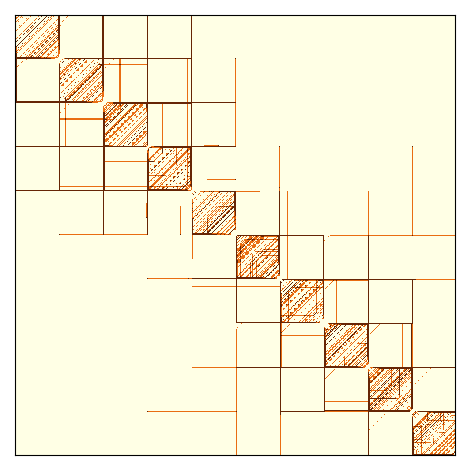

In [123]:
kymograph = map_from_lefs(np.asarray(hist_wap), sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False, cmap='YlOrBr') 
#plt.title('Lifetime=%s, separation=%s, velocity=%s'%(paramdict_CTCF['LEF_lifetime'][1], paramdict_CTCF['LEF_separation']
#                                                    ,paramdict_CTCF['velocity_multiplier']),fontsize=8.5)            
#plt.title('CTCF_offtime=%s, CTCF_facestall=%s' % (paramdict['CTCF_offtime'],
#                                                  paramdict['CTCF_facestall']),
#          fontsize=12)

plt.xticks([])
plt.yticks([])

plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.savefig('contact_map_wapl.png')
plt.show()  

In [126]:
paramdict_CTCF['velocity_multiplier'] = 3


translocator = make_translocator(LEFTranslocatorDynamicBoundary, 
                                 site_types,
                                 CTCF_left_positions,
                                 CTCF_right_positions, 
                                 **paramdict_CTCF)



hist_pds5 = []
for _ in range(trajectory_length):
    translocator.step()
    hist_pds5.append(translocator.LEFs.copy())

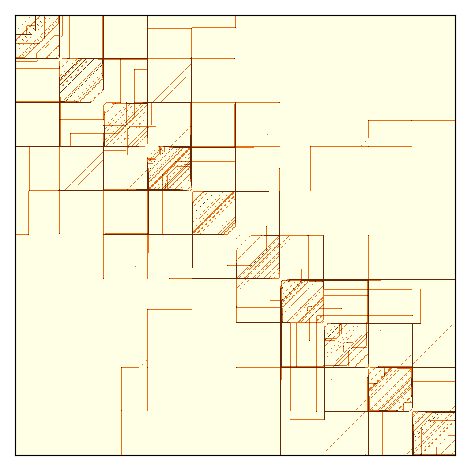

In [127]:
kymograph = map_from_lefs(np.asarray(hist_pds5), sites_per_replica)
                    
plt.matshow(np.log10(kymograph+1),vmax=1.5/(np.sqrt(paramdict['sites_per_monomer'])), fignum=False, cmap='YlOrBr') 
#plt.title('Lifetime=%s, separation=%s, velocity=%s'%(paramdict_CTCF['LEF_lifetime'][1], paramdict_CTCF['LEF_separation']
#                                                    ,paramdict_CTCF['velocity_multiplier']),fontsize=8.5)            
#plt.title('CTCF_offtime=%s, CTCF_facestall=%s' % (paramdict['CTCF_offtime'],
#                                                  paramdict['CTCF_facestall']),
#          fontsize=12)

plt.xticks([])
plt.yticks([])

plt.yticks(fontsize=10)
            
plt.tight_layout()
plt.savefig('contact_map_pds.png')
plt.show()                       
           